In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [74]:
data = pd.read_csv("../PrometneNesreče.csv")
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

C:\Users\Hana\AppData\Local\Temp\ipykernel_46652\558912415.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../PrometneNesreče.csv")


## Periodogram

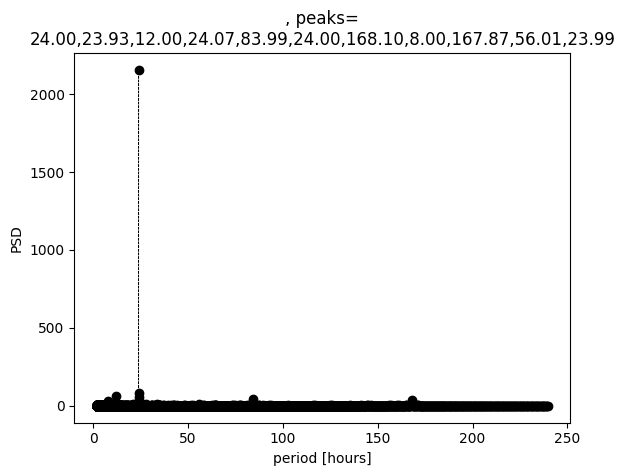

In [75]:
# Pridobi prvi timestamp in ga uporabi kot referenco za izračun ur
min_datum = data['NastanekDatumCas'].min()

# Pretvori vsak timestamp v število ur od začetnega timestamp-a
številka_ure = 24 * (data['NastanekDatumCas'] - min_datum).dt.days + data['NastanekDatumCas'].dt.hour

# Ustvari seznam, ki bo vseboval število nesreč v vsaki uri (napolni ga z ničlami)
count_ure = [0] * (številka_ure.max() + 1)

# V seznam vpiši število nesreč v vsaki uri
for x in številka_ure:
    count_ure[x] += 1


X = np.array(range(len(count_ure)))   # Ure od 0 do max ure
Y = np.array(count_ure)    # Število nesreč v vsaki uri

cosinor.periodogram(X, Y, max_per = 240)

#### Vrhovi
- 24.00: Zelo izrazit dnevni cikel-
- 12.00: Poldnevni cikel (mogoče prometne konice) | Possibly half-day cycle (e.g., rush hours)
- 168.10: Tedenski cikel (168 ur = 7 dni)
- 8.00:  8-urni cikel (mogoče delovne izmene)
- 83.99: ~3.5-dnevni cikel (ni čisto jasno, kaj bi to lahko bilo)
- 56.01: ~2.3-dnevni cikel (tudi tukaj ni čisto jasno, kaj bi to bilo. Mogoče kaj v povezavi z vikendi)

## Število prometnih nesreč po urah

In [76]:
# Število prometnih nesreč po urah

# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
# data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')
# print(f"NastanekDatumCas column dtype: {data['NastanekDatumCas'].dtype}")

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = data['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidents",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

#print(df_plot)

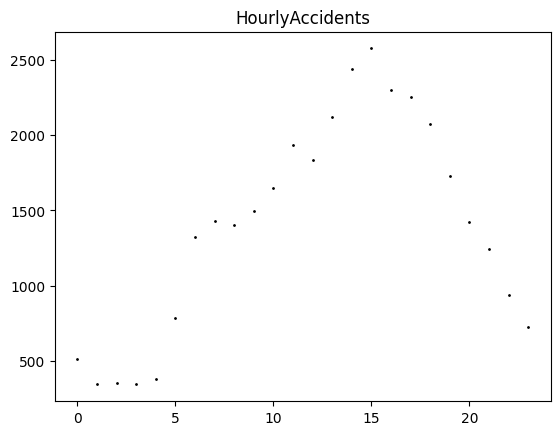

In [77]:
cosinor.plot_data(df_plot, names = ["HourlyAccidents"])

## CosinorPy

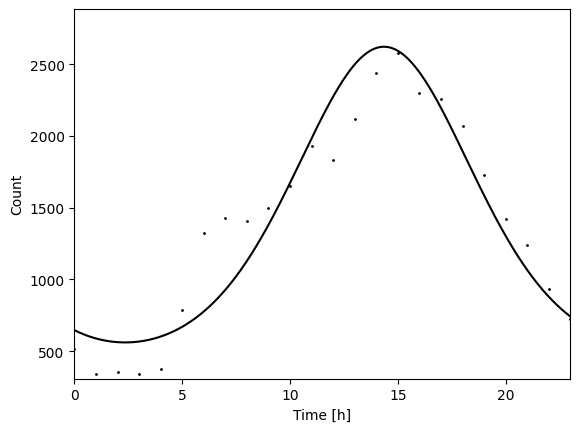

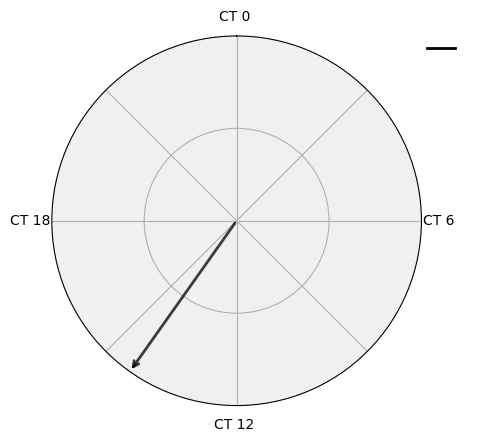

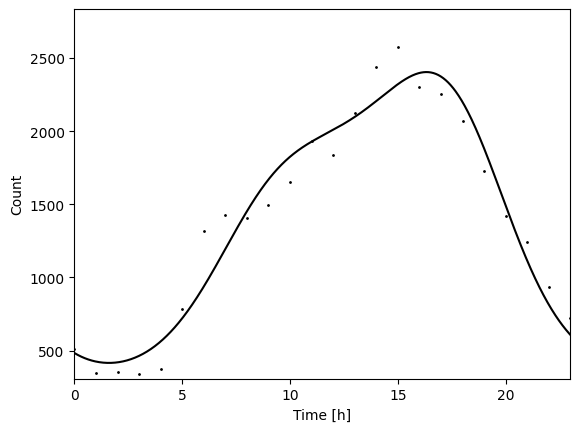

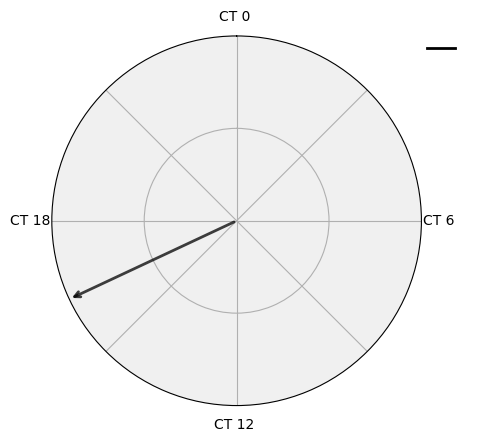

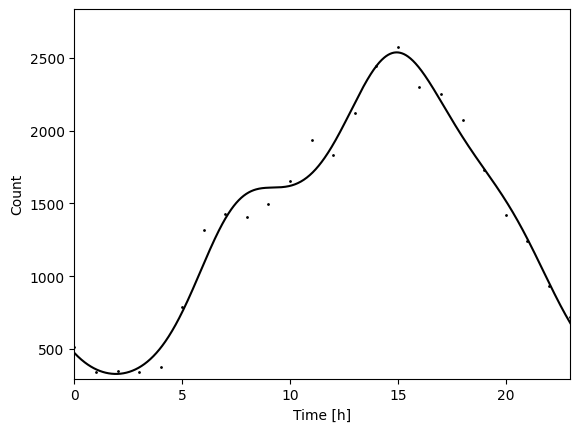

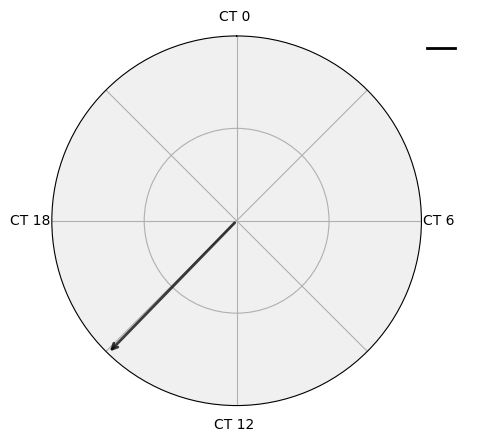

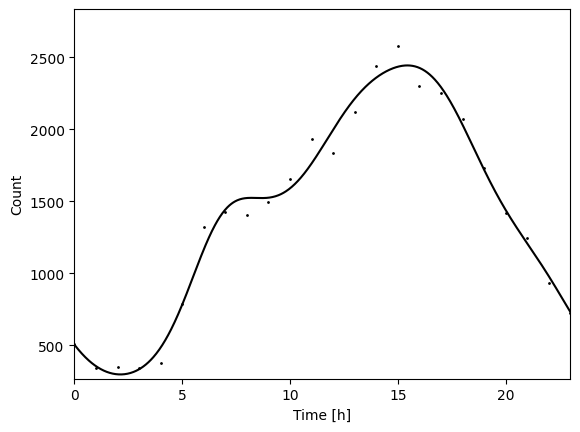

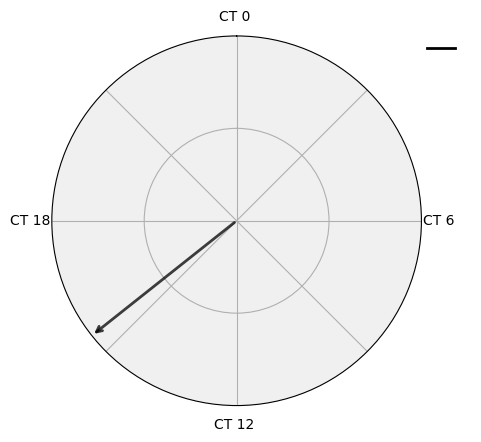

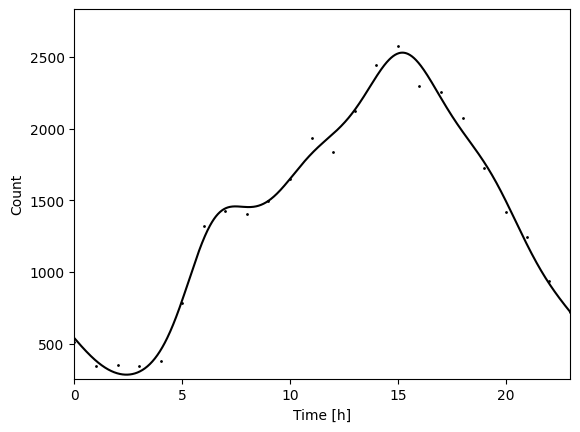

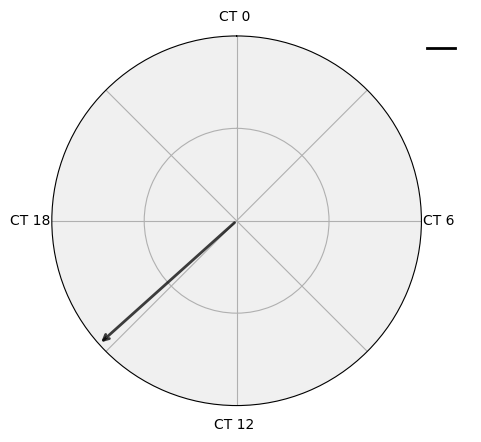

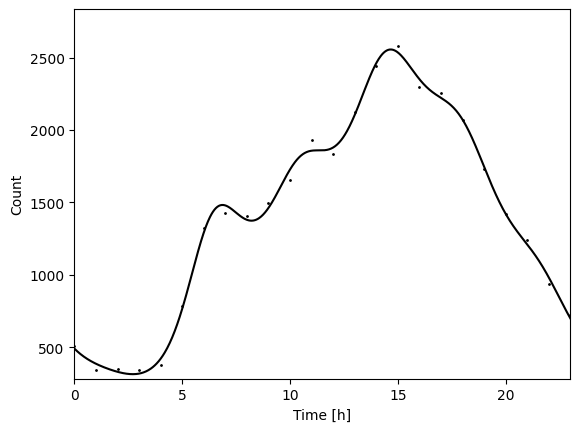

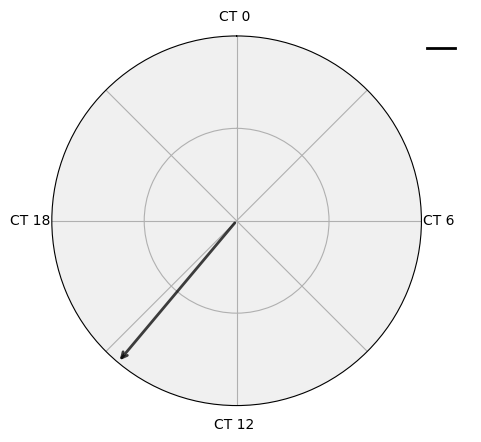

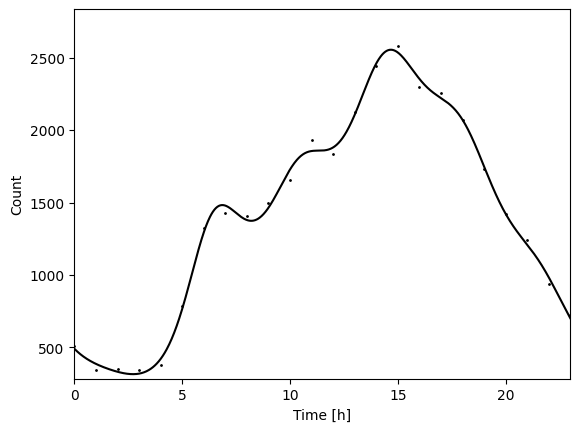

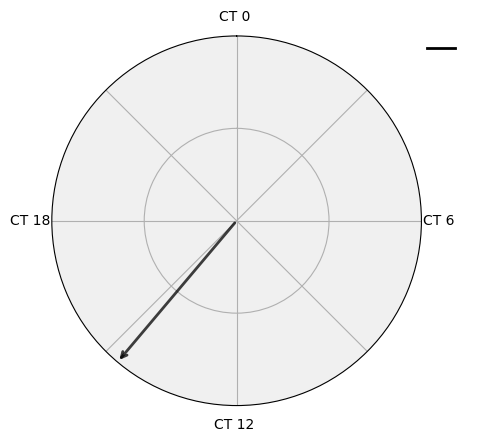

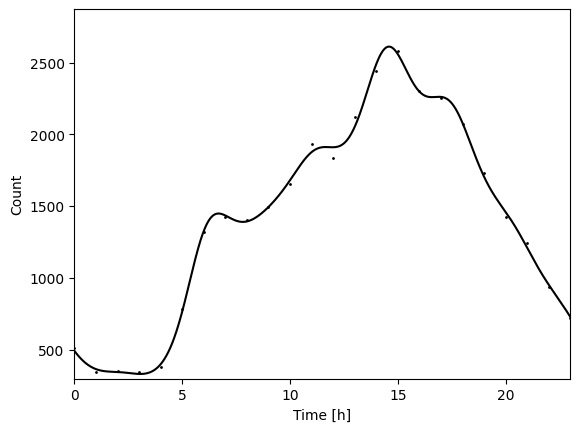

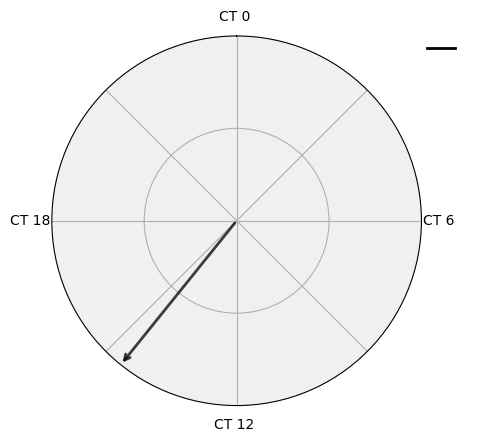

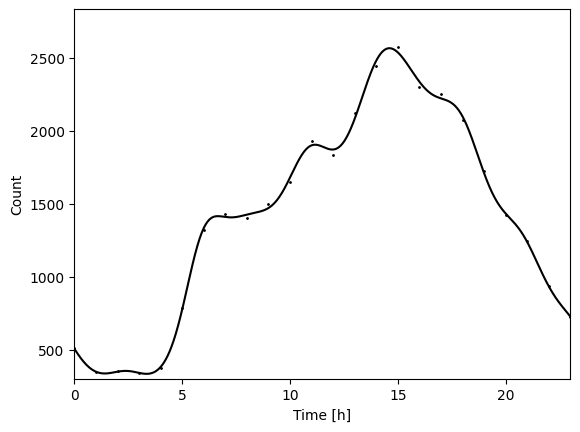

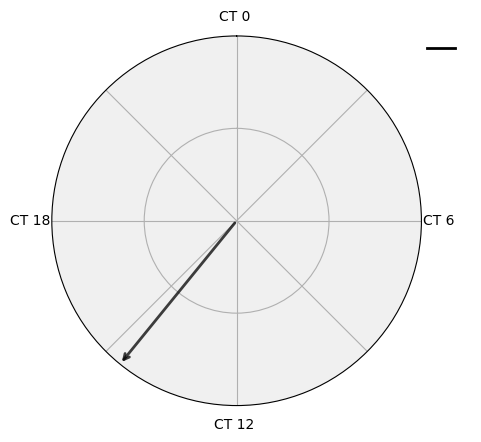

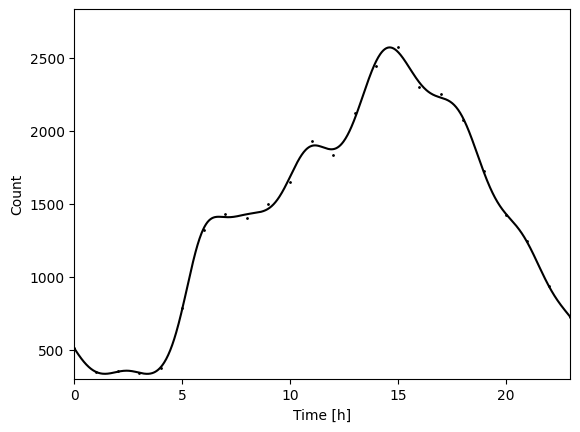

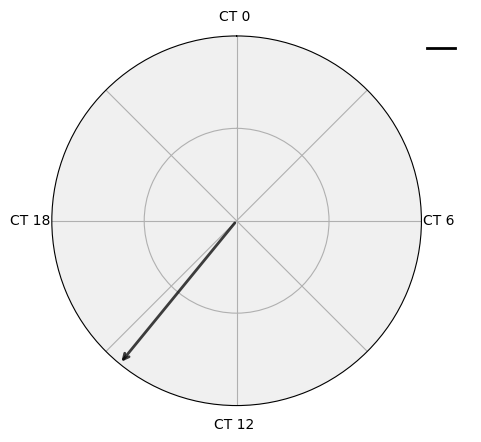

In [ ]:
#df_results = cosinor.fit_group(df_plot, n_components = [1,2,3,4,5,6,7,8], period = 24)

X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidents', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidents', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidents',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])


# results = {}
# for n in [1,2,3,4,5,6,7,8]:
#     results[n] = cosinor.fit_me(X, Y, n_components = 1, period = 24, model_type = 'gen_poisson')
#print(df_results)

In [79]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidents,24.0,1.0,1.556165e-12,1.556165e-12,1.366039e+06,-166.453951,0.140407,1030.841572,2.525465,1591.710564,[14.353435343534354],[2622.5519708580996],[2.3570357035703573],[560.8690419258202],340.907903,345.620118
1,HourlyAccidents,24.0,2.0,7.760546e-16,8.622828e-16,5.926444e+05,-155.174954,0.198653,994.243706,2.008935,1410.141223,[16.32643264326433],[2404.38467197493],[1.6033603360336035],[415.8975871440162],322.349908,329.418231
2,HourlyAccidents,24.0,3.0,1.397844e-19,1.747305e-19,2.259181e+05,-143.033949,0.261351,1104.264508,2.370883,1433.383168,[14.943894389438945],[2537.647675126909],[1.92979297929793],[329.1188621401511],302.067899,311.492329
3,HourlyAccidents,24.0,4.0,3.696100e-20,5.280142e-20,1.710043e+05,-138.611382,0.284190,1073.047811,2.241436,1370.665069,"[8.20882088208821, 15.43834383438344]","[1523.9986842953979, 2443.7128800740143]",[2.1314131413141317],[297.6173463350724],297.222764,309.003302
4,HourlyAccidents,24.0,5.0,6.675358e-21,1.112560e-20,1.047245e+05,-133.939270,0.308318,1123.817010,2.301761,1407.123942,"[7.464746474647465, 15.207920792079209]","[1457.839857035292, 2530.940590548946]",[2.4146414641464147],[283.3069958976985],291.878541,306.015187
5,HourlyAccidents,24.0,6.0,1.711906e-24,4.279765e-24,3.459088e+04,-122.296525,0.368443,1120.732071,2.443775,1435.419547,"[6.86948694869487, 11.247524752475249, 14.6654...","[1482.7803724189178, 1859.5543049737494, 2556....","[2.7074707470747077, 8.213621362136214]","[314.6874760055509, 1374.178054409649]",272.593051,289.085804
6,HourlyAccidents,24.0,7.0,2.047986e-23,4.095972e-23,3.509824e+04,-122.286845,0.368493,1119.583657,2.441262,1434.896510,"[6.859885988598861, 14.675067506750676]","[1482.3366416263552, 2554.4801662357922]","[2.7170717071707173, 8.1992199219922]","[315.3128531494292, 1373.5908321455156]",276.573690,295.422552
7,HourlyAccidents,24.0,8.0,7.708206e-26,2.569402e-25,2.251400e+04,-113.572436,0.413495,1139.831831,2.463883,1470.941467,"[11.645964596459647, 14.58865886588659, 16.907...","[1911.449379155372, 2610.7732977122646, 2261.3...","[3.0531053105310533, 7.810381038103811]","[331.10963648993516, 1390.1207142338112]",263.144872,284.349841
8,HourlyAccidents,24.0,9.0,1.110441e-28,1.110441e-27,1.317920e+04,-103.803443,0.463944,1116.254959,2.458856,1450.551908,"[11.161116111611163, 14.607860786078609]","[1905.177161984815, 2566.8068673733305]","[1.4065406540654066, 3.3459345934593463, 7.258...","[336.8123913781772, 334.2969488217873, 1406.84...",247.606886,271.167962
9,HourlyAccidents,24.0,10.0,8.814949e-28,4.407474e-27,1.273973e+04,-103.535765,0.465326,1118.892629,2.456343,1453.381222,"[11.156315631563157, 14.61746174617462]","[1900.614883876386, 2572.2738512650317]","[1.4113411341134114, 3.3795379537953796, 7.128...","[334.74060093778996, 334.48859243796284, 1408....",251.071531,276.988715


### Najboljši model glede na likelihood-ratio test

In [80]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10], criterium='AIC', reverse = True)
df_best_model

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents,24,3,1.397844e-19,225918.147599,-143.033949,0.261351,302.067899,311.492329,1104.264508,2.370883,1433.383168,[14.943894389438945],[2537.647675126909],[1.92979297929793],[329.1188621401511]


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  try:


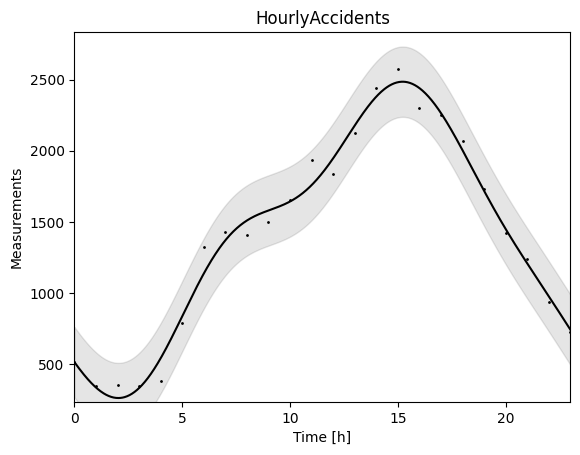

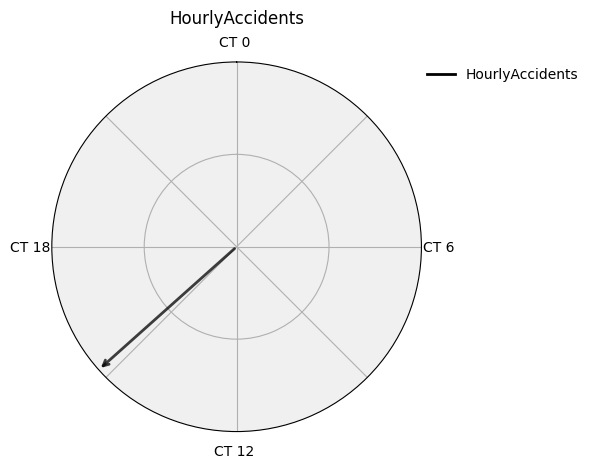

In [81]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [82]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidents",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [83]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

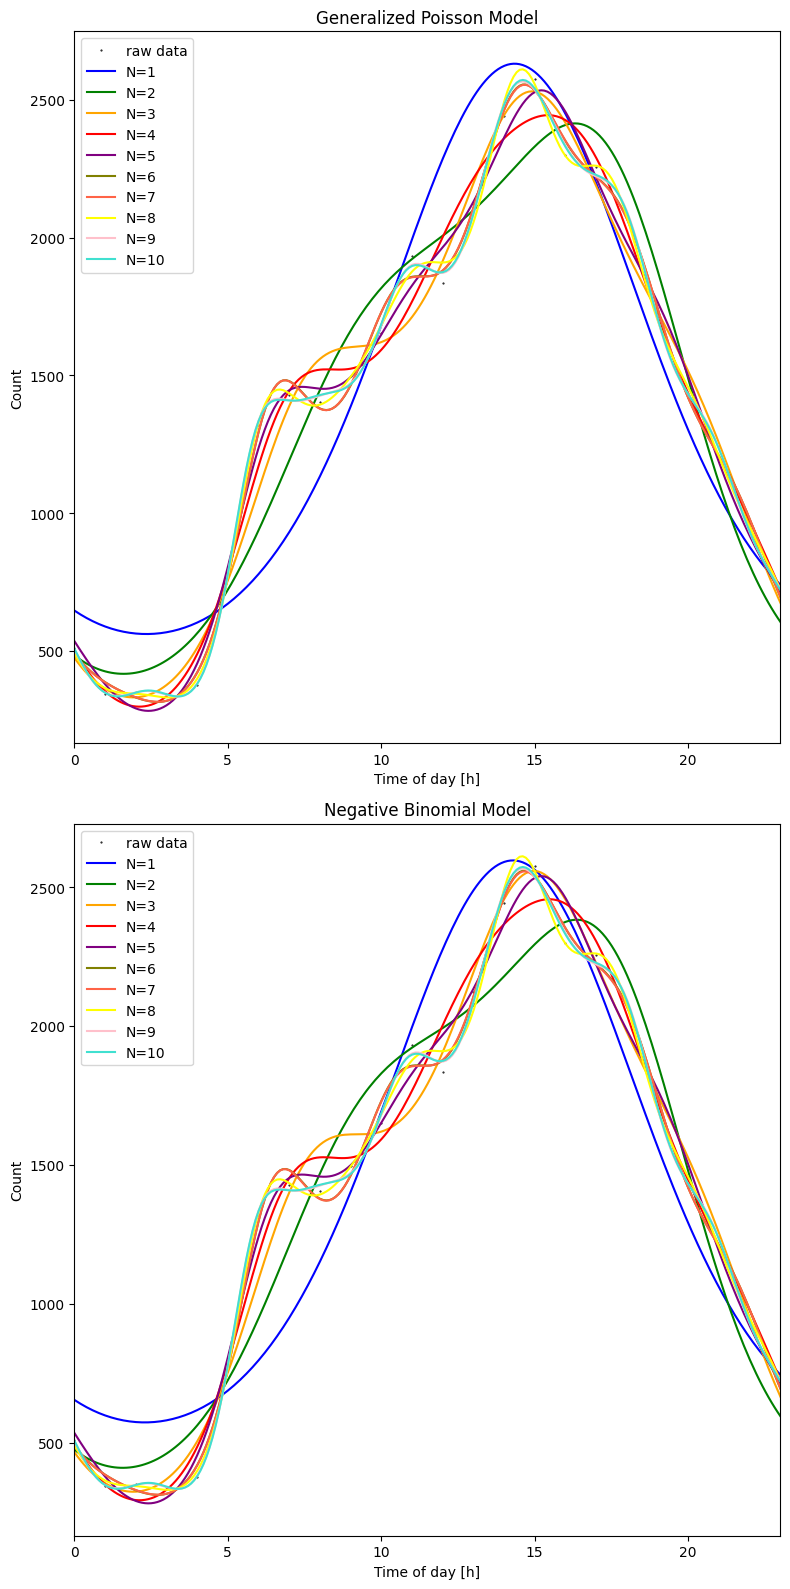

In [84]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [85]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,1034.79,1596.17,[14.31],[2630.96],1.560009e-12,1.377479e+06,340.912837,345.625052,-166.456418,"[-6.160534051243644, -6.868787986100642, -6.54...",1403.416079,"[646.5731588997752, 588.6970534145836, 563.142...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[646.5731588997752, 639.2094923218618, 632.208..."
1,gen_poisson,2,998.73,1415.68,[16.32],[2414.4],7.827463e-16,5.888600e+05,322.367526,329.435849,-155.183763,"[-5.640474626559353, -5.647926915922994, -5.54...",1400.321245,"[484.07525398802204, 425.9385370602824, 420.89...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[484.07525398802204, 475.58314430799857, 467.7..."
2,gen_poisson,3,1099.60,1431.05,[14.91],[2530.64],1.588845e-19,2.248220e+05,302.334389,311.758820,-143.167194,"[-5.240339071609014, -4.833140645040032, -4.92...",1398.099759,"[474.7785277743265, 363.06070871449214, 331.65...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[474.7785277743265, 459.59009515416994, 445.32..."
3,gen_poisson,4,1073.19,1370.99,[15.42],[2444.18],3.815141e-20,1.697111e+05,297.289748,309.070287,-138.644874,"[-4.8684066828884625, -4.648436346952565, -5.6...",1399.958333,"[501.4881588677294, 353.67990642532794, 298.40...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[501.4881588677294, 482.5810596518304, 464.541..."
4,gen_poisson,5,1125.99,1408.50,[15.22],[2534.49],6.770343e-21,1.054282e+05,291.908790,306.045436,-133.954395,"[-4.799300382894671, -4.9226915406219405, -6.1...",1399.938541,"[535.6983605679029, 379.3698038685295, 291.424...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[535.6983605679029, 518.3340219348571, 501.209..."
5,gen_poisson,6,1120.36,1435.22,[14.71],[2555.58],3.004355e-24,3.458893e+04,273.801783,290.294537,-122.900892,"[-4.468026656331006, -6.333523562738662, -4.50...",1399.958333,"[491.263046076772, 386.68312619910307, 331.073...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[491.263046076772, 476.9210038958209, 463.6266..."
6,gen_poisson,7,1119.36,1434.81,[14.71],[2554.17],3.542610e-23,3.505850e+04,277.769146,296.618007,-122.884573,"[-4.503459368196388, -6.287385188385599, -4.45...",1399.958333,"[490.4606997916878, 386.2930057040962, 331.800...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[490.4606997916878, 476.0540774557646, 462.721..."
7,gen_poisson,8,1139.70,1470.96,"[14.61, 16.92]","[2610.66, 2261.52]",9.826379e-26,2.253178e+04,263.676364,284.881333,-113.838182,"[-4.452654904834901, -4.484730993259802, -3.83...",1399.958333,"[491.4602516495636, 364.77338277947484, 344.67...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[491.4602516495636, 472.07370487491784, 454.10..."
8,gen_poisson,9,1115.93,1450.58,[14.61],[2566.51],7.622120e-27,1.317823e+04,256.904346,280.465422,-108.452173,"[-3.969257312373486, -3.777491429968336, -3.75...",1399.958333,"[506.06608413599486, 349.1283896680374, 349.34...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[506.06608413599486, 483.318962796222, 461.609..."
9,gen_poisson,10,1118.63,1453.42,[14.61],[2572.05],6.716260e-26,1.273727e+04,260.715806,286.632990,-108.357903,"[-3.942813356321608, -3.761101805769954, -3.75...",1399.958333,"[508.3505436795946, 348.16061416303194, 348.79...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[508.3505436795946, 485.71602731798447, 463.96..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [86]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model1 = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model1.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [87]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model2 = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model2.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

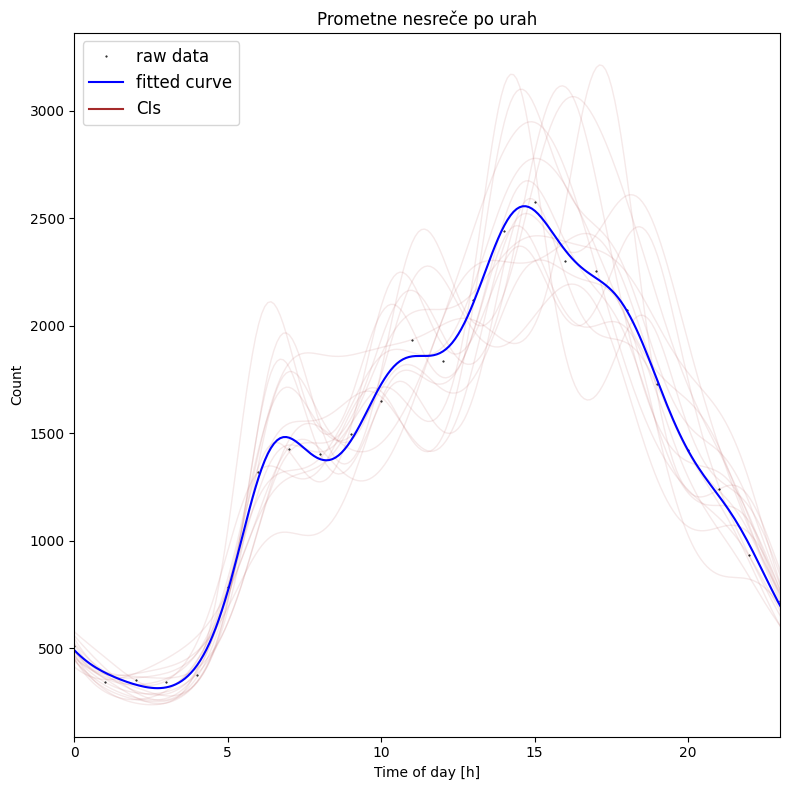

Intervali zaupanja:


,0,1
0,6.988696,7.121175
1,-0.551051,-0.317492
2,-0.819592,-0.662749
3,-0.314401,-0.105072
4,-0.300060,-0.120722
5,-0.213773,-0.094638
6,-0.020572,0.162374
7,-0.079522,0.047092
8,-0.004416,0.142323
9,-0.016915,0.107924


In [88]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model1.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [72]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model1['peaks'])
best_model = pd.concat([best_model1, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,1120.36
mesor,1435.22
peaks,[14.71]
heights,[2555.58]
amplitude_CIs,"[1038.38, 1207.39]"
mesor_CIs,"[1368.89, 1520.33]"
peaks_CIs,"[13.79, 15.62]"
heights_CIs,"[2351.28, 2751.37]"
